## What is this?
Now we have some utilities we used often. It's time to make it more useful.

In [49]:
import sys
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.visualize_util import plot
from matplotlib.pyplot import show, plot
import pandas as pd
import numpy as np
import math
import random
random.seed(0)

model_name = "sony_fitting"

def weights_dir(model_version):
    return "{0}/Desktop/{1}-{2}".format(os.environ['HOME'], model_name, model_version)

def best_weights_path(model_version):
    files = os.listdir(weights_dir(model_version))
    files.sort()
    return "{0}/{1}".format(weights_dir(model_version), files[0])

def default_callback_list(model_version):
    os.makedirs(weights_dir(model_version), exist_ok=True)
    filepath = weights_dir(model_version) + "/{loss:.4f}"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    return [checkpoint]

    
print(weights_dir(1))
#print(best_model_path(1))
print(default_callback_list(1))


/Users/higepon/Desktop/sony_fitting-1


## Let's use this for Sony data

In [34]:
# load
df = pd.read_csv("../../dont_remove_data/sony.csv", header=None)
df[1] = df[1].astype('float32')
df[1] = df[1].apply(lambda x: x / 10000)
prices = df[1]
print("prices.shape", prices.shape)


prices.shape (2449,)


In [30]:
# we use last 200 days data
nb_prev = 200 # to be 200

X = []
Y = []

for i in range(len(prices)-nb_prev):
    X.append(prices.iloc[i:i+nb_prev].as_matrix())
    mixed_Y_i = np.array([prices.iloc[i+nb_prev], 1 if prices.iloc[i+nb_prev] - prices.iloc[i+nb_prev - 1] > 0 else 0])
    Y.append(mixed_Y_i)
    if i == 0:
        print(mixed_Y_i)

X = np.array(X).reshape(-1, nb_prev, 1)
print("X.shape", X.shape)
Y = np.array(Y)
#Y = np.array(Y).reshape(-1, 2)
print("Y.shape", Y.shape)


[ 0.518  0.   ]
X.shape (2249, 200, 1)
Y.shape (2249, 2)


In [35]:
# randomly split the data
test_size = 0.1
nb_train = int(round(len(X) * (1 - test_size)))
print("test_data_size", len(X) - nb_train)
shuffle = False

if shuffle:
    indices = np.random.permutation(X.shape[0])
    training_idx, test_idx = indices[:nb_train], indices[nb_train:]
    X_train, X_test = X[training_idx,:], X[test_idx,:]
    Y_train, Y_test = Y[training_idx,:], Y[test_idx,:]
else:
    X_train, X_test = X[:nb_train], X[nb_train:]
    Y_train, Y_test = Y[:nb_train], Y[nb_train:]    

print(X_train.shape)
print(Y_train.shape)
print("X_test.shape", X_test.shape)
print("Y_test.shape", Y_test.shape)

test_data_size 225
(2024, 200, 1)
(2024, 2)
X_test.shape (225, 200, 1)
Y_test.shape (225, 2)


In [38]:
in_out_neurons = 1
hidden_neurons = 300
length_of_sequences = nb_prev
model = Sequential()  
model.add(LSTM(hidden_neurons, batch_input_shape=(None, nb_prev, in_out_neurons), return_sequences=False))  
model.add(Dense(2))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="adam")

print(model.summary)

<bound method Container.summary of <keras.models.Sequential object at 0x116833438>>


In [45]:
def train(model_version):
    print(X_train.shape)
    print(Y_train.shape)
    model.fit(X_train, Y_train, batch_size=600, nb_epoch=20, validation_split=0.05, callbacks=default_callback_list(model_version))
    
train(1)



(2024, 200, 1)
(2024, 2)
Train on 1922 samples, validate on 102 samples
Epoch 1/20
1922/1922 [==============================] - 53s - loss: 0.1431 - val_loss: 0.1257
Epoch 2/20
1922/1922 [==============================] - 54s - loss: 0.1356 - val_loss: 0.1307
Epoch 3/20
1922/1922 [==============================] - 55s - loss: 0.1347 - val_loss: 0.1264
Epoch 4/20
1922/1922 [==============================] - 57s - loss: 0.1284 - val_loss: 0.1329
Epoch 5/20
1922/1922 [==============================] - 61s - loss: 0.1283 - val_loss: 0.1252
Epoch 6/20
1922/1922 [==============================] - 63s - loss: 0.1263 - val_loss: 0.1256
Epoch 7/20
1922/1922 [==============================] - 64s - loss: 0.1268 - val_loss: 0.1250
Epoch 8/20
1922/1922 [==============================] - 56s - loss: 0.1261 - val_loss: 0.1283
Epoch 9/20
1922/1922 [==============================] - 51s - loss: 0.1264 - val_loss: 0.1255
Epoch 10/20
1922/1922 [==============================] - 59s - loss: 0.1254 - val_

In [56]:
print(best_weights_path(1))
model.load_weights(best_weights_path(1))   
predicted = model.predict(X_test)
print(predicted.shape)


/Users/higepon/Desktop/sony_fitting-1/0.1250
(225, 2)


In [57]:
prices_prediction = predicted[:,0]
up_down_prediction = predicted[:,1]
print(up_down_prediction)

[ 0.46565825  0.46585155  0.46629769  0.46680111  0.46728373  0.46774951
  0.46820939  0.4686074   0.46892369  0.46910295  0.46917602  0.46921325
  0.46923596  0.46931732  0.46945363  0.46957457  0.46970177  0.46981016
  0.46987319  0.46991974  0.46998319  0.47002846  0.47007364  0.47013754
  0.47021344  0.47034314  0.47052783  0.4707036   0.4708851   0.47108775
  0.47133335  0.47161448  0.47188202  0.47215259  0.47242826  0.47269598
  0.47293746  0.47309113  0.47313681  0.47309661  0.47297162  0.47278792
  0.47255629  0.47226846  0.47187638  0.47141355  0.47095165  0.47049424
  0.47000399  0.46950018  0.46904361  0.46869293  0.46846852  0.46835688
  0.46822804  0.46805429  0.46790203  0.46783933  0.46783715  0.46785593
  0.46785086  0.46779445  0.46775216  0.46765482  0.46745279  0.46719193
  0.46689302  0.46664286  0.4664312   0.46629977  0.46628559  0.46635011
  0.46647316  0.46669093  0.46696272  0.46725503  0.46753147  0.46781558
  0.46815658  0.46851939  0.46886697  0.4691624   0

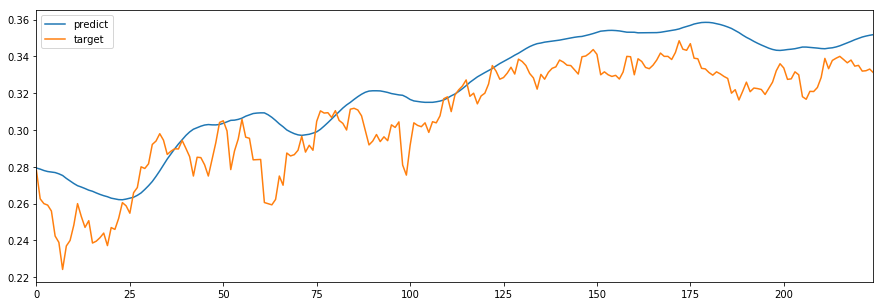

In [58]:
dataf =  pd.DataFrame(prices_prediction)
dataf.columns = ["predict"]
dataf["target"] = Y_test[:,0]
dataf.plot(figsize=(15, 5))
show()    

In [59]:
# accuracy

# predicted is (N, 2) 2 is two classes
# convert it to (N, 1) where 1 is class label 0 or 1
predicted_classes = np.around(up_down_prediction)
target_classes = Y_test[:,1]
print(predicted_classes)
print(target_classes)


# how many samples match target
correct = np.sum(predicted_classes == target_classes)

# accuracy = number correct / total number
accuracy = correct / (len(Y_test) * 1.0)
print("accuracy = ", accuracy)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.
  1.  0.  1. 